Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Load California Wildfires Data

In [2]:
def load_data(train_path, dev_path, test_path):
    train_df = pd.read_csv(train_path, sep="\t")
    dev_df = pd.read_csv(dev_path, sep="\t")
    test_df = pd.read_csv(test_path, sep="\t")

    # Combine train data and dev data for better training
    train_df = pd.concat([train_df, dev_df], ignore_index=True)
    return train_df, test_df

train_path = "/content/california_wildfires_2018_train.tsv"
dev_path = "/content/california_wildfires_2018_dev.tsv"
test_path = "/content/california_wildfires_2018_test.tsv"

train_df, test_df = load_data(train_path, dev_path, test_path)

In [3]:
train_df

,tweet_id,tweet_text,class_label
0,1061651759158853632,Smoking ruins and a mobile DNA lab: California...,injured_or_dead_people
1,1064599072151990273,"California’s utility, PG&amp;E was responsible...",other_relevant_information
2,1061239977282072577,At least 9 dead in California wildfires as ten...,injured_or_dead_people
3,1063608886995898368,RT @WGNNews: At least 66 dead in California wi...,injured_or_dead_people
4,1064157198350086145,25K - + homeless &amp; from the #DeranfgedOran...,injured_or_dead_people
...,...,...,...
5910,1062367936340475904,Death toll in California wildfires climbs to 4...,injured_or_dead_people
5911,1064442973633634304,Camp Fire death toll increases to 77; Survivor...,injured_or_dead_people
5912,1064479330796011520,2018: trump not impeached. r kelly not in jail...,not_humanitarian
5913,1065156034744983553,@RepJoeKennedy We are headed home from helping...,rescue_volunteering_or_donation_effort


In [4]:
test_df

,tweet_id,tweet_text,class_label
0,1061261657689735168,I can’t imagine hitting send on a tweet like t...,injured_or_dead_people
1,1064632155941347329,"#CampFire has killed 77 people, torched an are...",injured_or_dead_people
2,1063178139717787653,ὒ5 California Wildfire Update: As of Wednesday...,injured_or_dead_people
3,1065276503800324097,"Kanye West reportedly raises $500,000 for Cali...",rescue_volunteering_or_donation_effort
4,1065660221110906880,This morning @KTLA is having a telethon to rai...,rescue_volunteering_or_donation_effort
...,...,...,...
1456,1067439895893946369,@SenWarren Hahahaha thats not a tear gas canis...,other_relevant_information
1457,1063078170767826944,We mourn the devastating toll of California s ...,other_relevant_information
1458,1062989393378590720,Victims of Californias deadliest wildfire have...,injured_or_dead_people
1459,1062104931983876098,RT @CJPatruno: California fire: Camp Fire deat...,injured_or_dead_people


ALL DATA

In [5]:
tweet_data = pd.concat([train_df, test_df], ignore_index=True)

In [6]:
tweet_data['class_label'].value_counts()

,count
class_label,
injured_or_dead_people,1946
rescue_volunteering_or_donation_effort,1415
not_humanitarian,1318
other_relevant_information,1038
sympathy_and_support,472
infrastructure_and_utility_damage,422
displaced_people_and_evacuations,368
missing_or_found_people,179
caution_and_advice,139


Data Preprocessing

In [7]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"\@\w+|\#", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)
    return text.strip()

train_df["clean_text"] = train_df["tweet_text"].apply(clean_text)
test_df["clean_text"] = test_df["tweet_text"].apply(clean_text)

In [8]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_train = vectorizer.fit_transform(train_df["clean_text"])
X_test = vectorizer.transform(test_df["clean_text"])

In [9]:
label_mapping = {label: idx for idx, label in enumerate(train_df["class_label"].unique())}
y_train = train_df["class_label"].map(label_mapping)
y_test = test_df["class_label"].map(label_mapping)

Define confusion matrix

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, model_name, class_labels):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel("Predicted Labels", fontsize=10)
    plt.ylabel("Actual Labels", fontsize=10)
    plt.title(f"Confusion Matrix - {model_name}", fontsize=10)

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

    plt.show()

class_labels = list(label_mapping.keys())


In [11]:
def evaluate_model(y_true, y_pred, model_name):
    precision = precision_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n{model_name} Evaluation:")
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'F1 Score: {f1}')

    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

Decision Tree

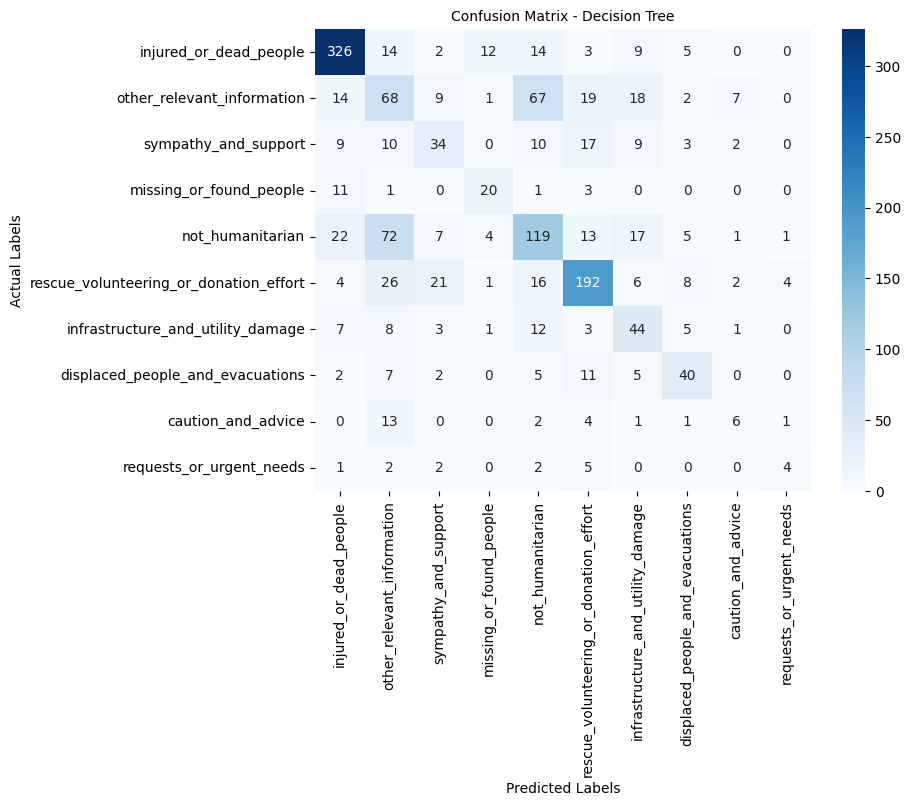


Decision Tree Evaluation:
Accuracy: 0.5838466803559206
Precision: 0.5843062374390815
F1 Score: 0.5828500268017458

 Classification Report:
                                        precision    recall  f1-score   support

                injured_or_dead_people       0.82      0.85      0.83       385
            other_relevant_information       0.31      0.33      0.32       205
                  sympathy_and_support       0.42      0.36      0.39        94
               missing_or_found_people       0.51      0.56      0.53        36
                      not_humanitarian       0.48      0.46      0.47       261
rescue_volunteering_or_donation_effort       0.71      0.69      0.70       280
     infrastructure_and_utility_damage       0.40      0.52      0.46        84
      displaced_people_and_evacuations       0.58      0.56      0.57        72
                    caution_and_advice       0.32      0.21      0.26        28
              requests_or_urgent_needs       0.40      0.25

In [12]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, recall_score

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

plot_confusion_matrix(y_test, dt_preds, "Decision Tree", class_labels)
evaluate_model(y_test, dt_preds,"Decision Tree")


Random Forest

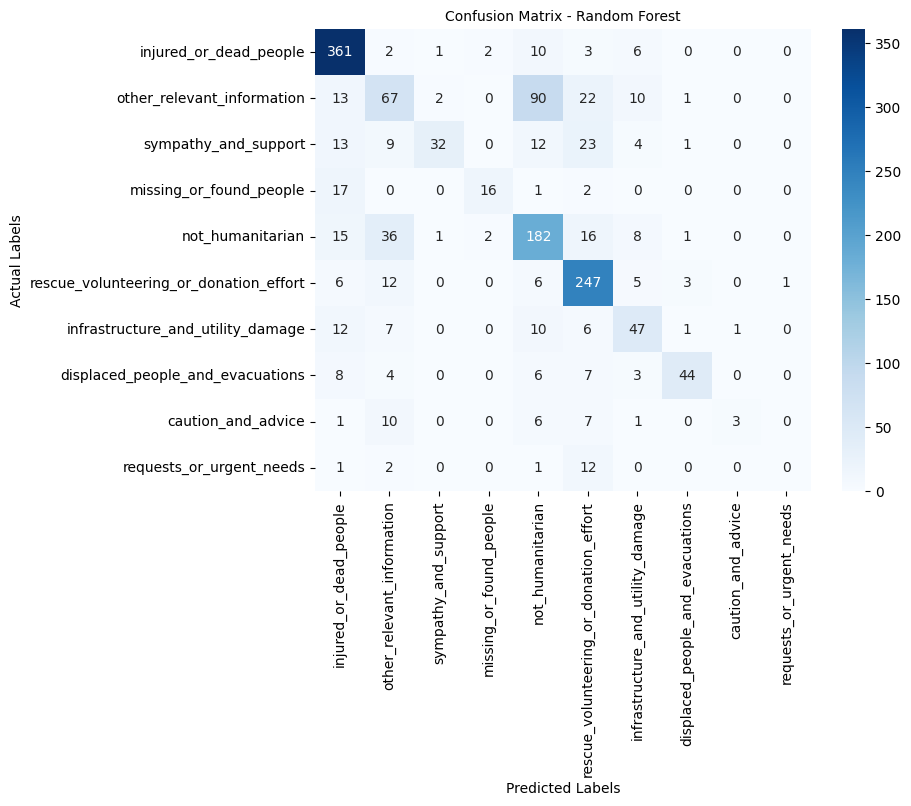


Random Forest Evaluation:
Accuracy: 0.6837782340862423
Precision: 0.679437167370454
F1 Score: 0.6612046369056178

 Classification Report:
                                        precision    recall  f1-score   support

                injured_or_dead_people       0.81      0.94      0.87       385
            other_relevant_information       0.45      0.33      0.38       205
                  sympathy_and_support       0.89      0.34      0.49        94
               missing_or_found_people       0.80      0.44      0.57        36
                      not_humanitarian       0.56      0.70      0.62       261
rescue_volunteering_or_donation_effort       0.72      0.88      0.79       280
     infrastructure_and_utility_damage       0.56      0.56      0.56        84
      displaced_people_and_evacuations       0.86      0.61      0.72        72
                    caution_and_advice       0.75      0.11      0.19        28
              requests_or_urgent_needs       0.00      0.00 

In [13]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

plot_confusion_matrix(y_test, rf_preds, "Random Forest", class_labels)
evaluate_model(y_test, rf_preds,"Random Forest")

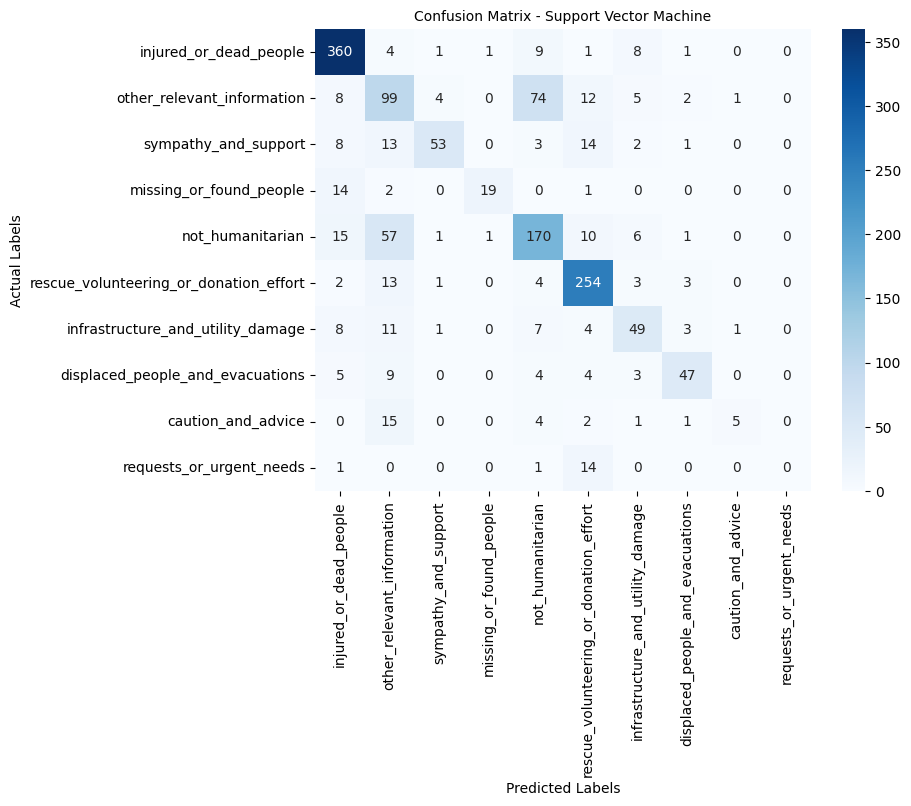


Support Vector Machine Evaluation:
Accuracy: 0.7227926078028748
Precision: 0.7194410121219921
F1 Score: 0.7130353092321935

 Classification Report:
                                        precision    recall  f1-score   support

                injured_or_dead_people       0.86      0.94      0.89       385
            other_relevant_information       0.44      0.48      0.46       205
                  sympathy_and_support       0.87      0.56      0.68        94
               missing_or_found_people       0.90      0.53      0.67        36
                      not_humanitarian       0.62      0.65      0.63       261
rescue_volunteering_or_donation_effort       0.80      0.91      0.85       280
     infrastructure_and_utility_damage       0.64      0.58      0.61        84
      displaced_people_and_evacuations       0.80      0.65      0.72        72
                    caution_and_advice       0.71      0.18      0.29        28
              requests_or_urgent_needs       0.00 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [14]:
svm_model = SVC(kernel="linear", random_state=42)
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

plot_confusion_matrix(y_test, svm_preds, "Support Vector Machine", class_labels)
evaluate_model(y_test, svm_preds,"Support Vector Machine")